# Univariate ARIMA Models

In [49]:
import warnings
warnings.filterwarnings('ignore')

In [50]:
%matplotlib inline

from tqdm import tqdm
from itertools import product
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
sns.set_style('whitegrid')

In [66]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0], auto_ylims=True)
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1], auto_ylims=True)
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## Download Series

Load monthly industrial production and daily NASDAQ stock market index:

In [40]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2017-12-31').squeeze().dropna()

### Log Transformation

In [41]:
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

### Differencing

In [42]:
nasdaq_log_diff = nasdaq_log.diff().dropna()

# seasonal differencing => yoy instantanteous returns
industrial_production_log_diff = industrial_production_log.diff(12).dropna()

## Univariate Time Series Models

### Autoregressive (AR) Model

Multiple linear-regression models expressed the variable of interest as a linear combination of predictors or input variables. Univariate time series models relate the value of the time series at the point in time of interest to a linear combination of lagged values of the series and possibly past disturbance terms.
While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data. ARIMA(p, d, q) models require stationarity and leverage two building blocks:
- Autoregressive (AR) terms consisting of p-lagged values of the time series
- Moving average (MA) terms that contain q-lagged disturbances


Chapter 8 introduces the ARIMA building blocks, simple autoregressive (AR) and moving average (MA) models, and explains how to combine them in autoregressive moving-average (ARMA) models that may account for series integration as ARIMA models or include exogenous variables as AR(I)MAX models. 

Furthermore, we will illustrate how to include seasonal AR and MA terms to extend the toolbox to also include SARMAX models.

### ARMA vs ARIMA

The ARMA model of the undifferenced series produces the same result as the ARIMA model of the differenced series.

In [43]:
nasdaq_log = nasdaq_log.asfreq('B')
industrial_production_log = industrial_production_log.asfreq('MS')
industrial_production_log_diff = industrial_production_log_diff.asfreq('MS')

In [73]:
#This probably doesn't exist anymore
#model1 = tsa.ARMA(endog=nasdaq_log_diff, order=(2,2)).fit()
model2 = tsa.ARIMA(endog=nasdaq_log, order=(2,0,2)).fit()

In [74]:
model1.params.sort_index() == model2.params.sort_index().values

ValueError: ('Lengths must match to compare', (5,), (6,))

### Seasonal differencing vs SARIMAX

Seasonal differencing has same effect as using SARIMAX w seasonal order (0,1,0,12).

In [75]:
model1 = tsa.statespace.SARIMAX(industrial_production_log, order=(2,0,2), seasonal_order=(0,1,0,12)).fit()
model2 = tsa.statespace.SARIMAX(industrial_production_log_diff, order=(2,0,2), seasonal_order=(0,0,0,12)).fit()

In [76]:
model1.params.to_frame('SARIMAX').join(model2.params.to_frame('diff'))

,SARIMAX,diff
ar.L1,1.769467,1.769467
ar.L2,-0.791823,-0.791823
ma.L1,-0.845315,-0.845315
ma.L2,0.313131,0.313131
sigma2,0.000102,0.000102


## Finding the optimal ARMA lags

### Run candidate models

We iterate over various (p, q) lag combinations and collect diagnostic statistics to compare the result.

In [77]:
train_size = 120
results = {}
y_true = industrial_production_log_diff.iloc[train_size:]
for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(industrial_production_log_diff)):
            train_set = industrial_production_log.iloc[T-train_size:T]
            try:
                model = tsa.ARIMA(endog=train_set, order=(p, 0, q)).fit() #tsa.ARMA(endog=train_set, order=(p, q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1

            forecast = model.forecast(steps=1)
            y_pred.append(forecast[0])
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))

        results[(p, q)] = [rmse,
                           np.mean(aic),
                           np.mean(bic),
                           convergence_error,
                           stationarity_error]

0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


1 0


/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

1 1


/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

1 2


/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

KeyboardInterrupt: 

In [78]:
arma_results = pd.DataFrame(results).T
arma_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
arma_results.index.names = ['p', 'q']
arma_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24 entries, (0, 1) to (4, 4)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          24 non-null     float64
 1   AIC           24 non-null     float64
 2   BIC           24 non-null     float64
 3   convergence   24 non-null     float64
 4   stationarity  24 non-null     float64
dtypes: float64(5)
memory usage: 1.5 KB


In [79]:
with pd.HDFStore('/media/n1c0/SanDiskSSD/arima.h5') as store:
    store.put('arma', arma_results)

We aim to minimize both RMSE and BIC:

In [80]:
arma_results.nsmallest(5, columns=['RMSE'])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
0 1  4.494571 -346.342211 -337.979736          0.0           0.0
  2  4.516326 -406.111800 -394.961833          0.0           0.0
  3  4.526007 -446.295719 -432.358260          0.0           0.0
  4  4.526852 -475.123793 -458.398842          0.0           0.0
2 3  4.544310 -535.462130 -515.949688          0.0           0.0

In [81]:
arma_results.nsmallest(5, columns=['BIC'])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
1 1  4.547105 -539.031127 -527.881160          0.0           0.0
3 3  4.547116 -546.453124 -524.153190          0.0           0.0
1 2  4.546932 -537.990426 -524.052967          0.0           0.0
3 2  4.547921 -542.111286 -522.598844          0.0           0.0
  0  4.547087 -536.535258 -522.597800          0.0           0.0

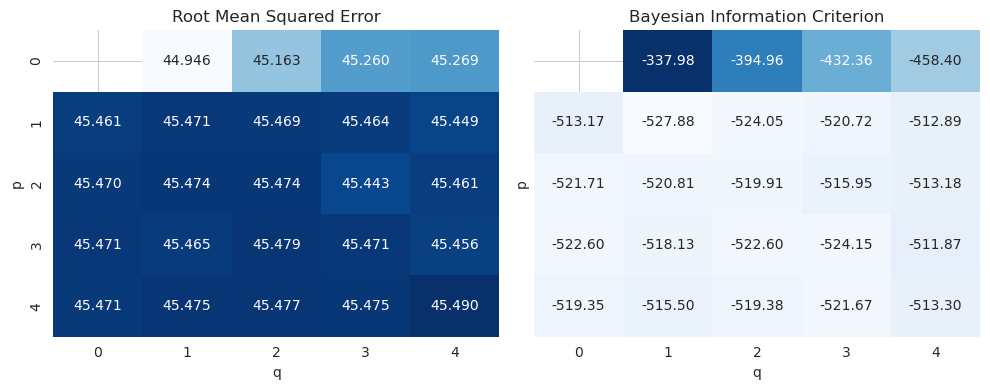

In [82]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharex=True, sharey=True)
sns.heatmap(arma_results[arma_results.RMSE<5].RMSE.unstack().mul(10), fmt='.3f', annot=True, cmap='Blues', ax=axes[0], cbar=False);
sns.heatmap(arma_results.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues', ax=axes[1], cbar=False)
axes[0].set_title('Root Mean Squared Error')
axes[1].set_title('Bayesian Information Criterion')
fig.tight_layout();

In [83]:
arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).nsmallest(5)

p  q
1  2    7.5
   1    8.5
   3    9.5
2  0    9.5
   3    9.5
dtype: float64

### Estimating the best ARMA Model

ARMA(4,0) and ARMA(4,1) are close, so we chose the more parsimonious (4,0) configuration:

In [84]:
best_p, best_q = arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).idxmin()

In [85]:
best_arma_model = tsa.ARIMA(endog=industrial_production_log_diff, order=(best_p, 0, best_q)).fit()
print(best_arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 IPGMFN   No. Observations:                  348
Model:                 ARIMA(1, 0, 2)   Log Likelihood                1081.894
Date:                Sat, 03 May 2025   AIC                          -2153.789
Time:                        15:47:04   BIC                          -2134.528
Sample:                    01-01-1989   HQIC                         -2146.121
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0207      0.021      0.987      0.324      -0.020       0.062
ar.L1          0.9625      0.011     86.558      0.000       0.941       0.984
ma.L1         -0.0563      0.041     -1.376      0.1

### Check Residual Correlogram

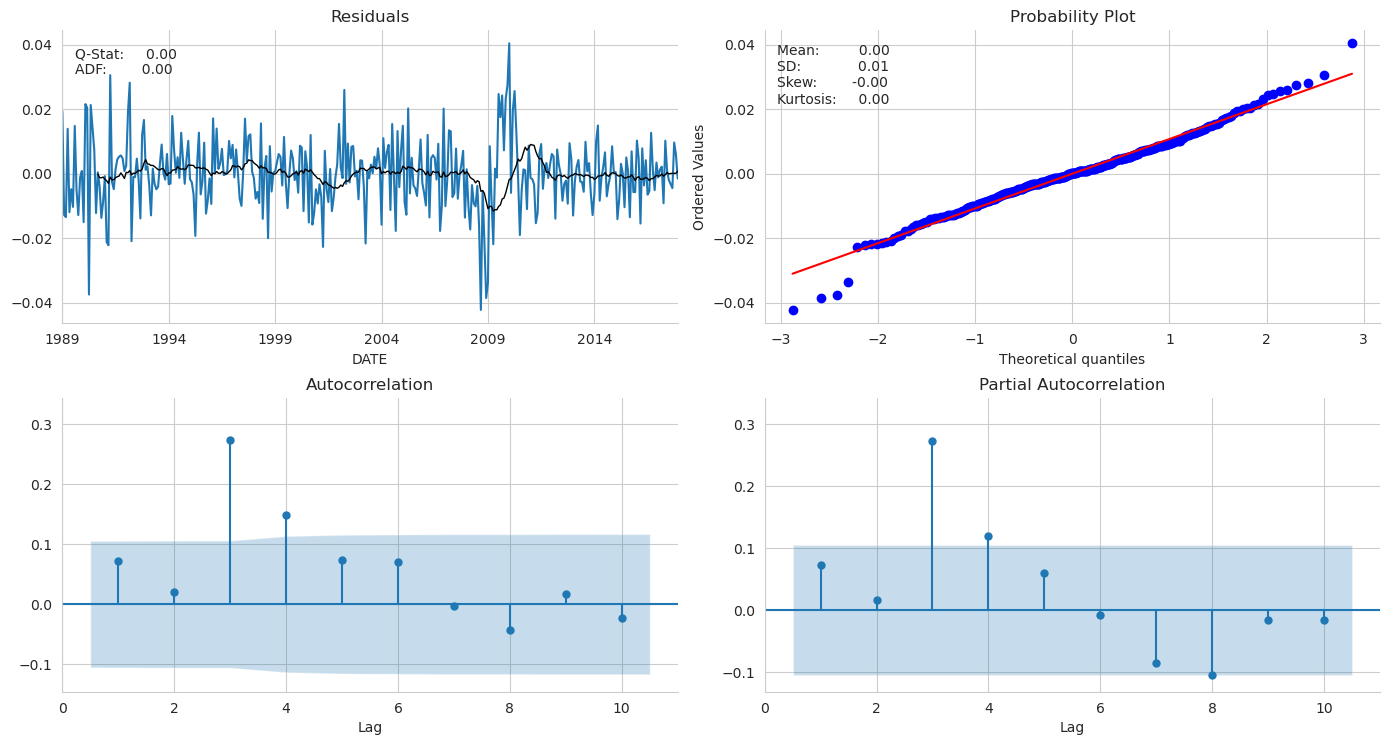

In [86]:
plot_correlogram(best_arma_model.resid)

## SARIMAX

In [87]:
sarimax_model = tsa.SARIMAX(endog=industrial_production_log_diff.dropna().values,
                    order=(2, 0, 2),
                    seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1])

In [88]:
print(sarimax_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                1126.809
Date:                              Sat, 03 May 2025   AIC                          -2239.617
Time:                                      15:47:36   BIC                          -2212.652
Sample:                                           0   HQIC                         -2228.882
                                              - 348                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0132      0.516      0.026      0.980      -0.998       1.024
ar.L2          0.98

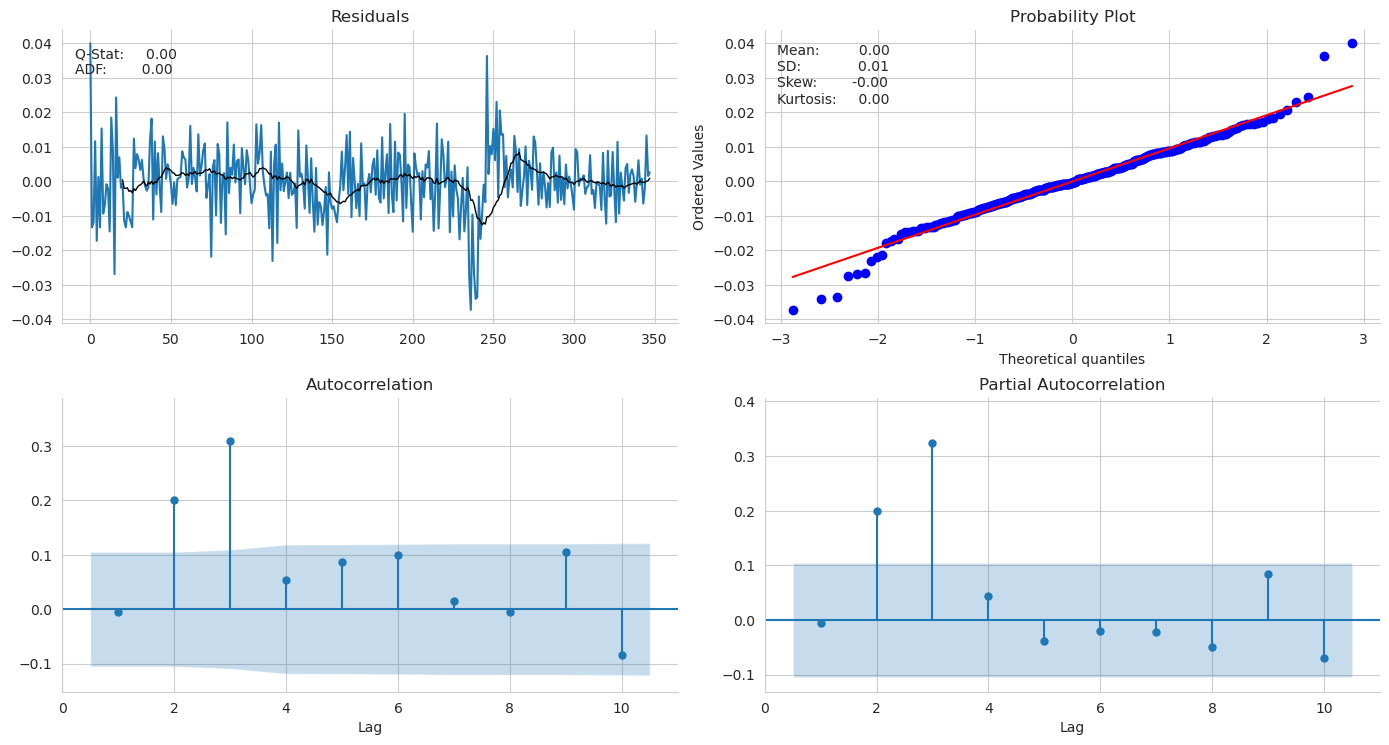

In [89]:
plot_correlogram(pd.Series(sarimax_model.resid))

We will build a SARIMAX model for monthly data on an industrial production time series for the 1988-2017 period. As illustrated in the first section on analytical tools, the data has been log-transformed, and we are using seasonal (lag-12) differences. We estimate the model for a range of both ordinary and conventional AR and MA parameters using a rolling window of 10 years of training data, and evaluate the RMSE of the 1-step-ahead forecast.

### Finding the optimal number of lags

This takes a while...

In [90]:
l3 = list(range(3))
l4 = list(range(4))
params = [t for t in product(l4, l4, l3, l3) if t[0] > 0 and t[1] >  0]
len(params)

81

In [91]:
train_size = 120 # 10 years of training data
results = {}
test_set = industrial_production_log_diff.iloc[train_size:]

for p1, q1, p2, q2 in tqdm(params):
    preds = test_set.copy().to_frame('y_true').assign(y_pred=np.nan)
    aic, bic = [], []
    if p1 == 0 and q1 == 0:
        continue
    convergence_error = stationarity_error = 0
    y_pred = []
    for i, T in enumerate(range(train_size, len(industrial_production_log_diff))):
        train_set = industrial_production_log_diff.iloc[T-train_size:T]
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = tsa.SARIMAX(endog=train_set.values,
                                order=(p1, 0, q1),
                                seasonal_order=(p2, 0, q2, 12)).fit(disp=0)
        except LinAlgError:
            convergence_error += 1
        except ValueError:
            stationarity_error += 1

        preds.iloc[i, 1] = model.forecast(steps=1)[0]
        aic.append(model.aic)
        bic.append(model.bic)

    preds.dropna(inplace=True)
    mse = mean_squared_error(preds.y_true, preds.y_pred)
    results[(p1, q1, p2, q2)] = [np.sqrt(mse),
                                      preds.y_true.sub(preds.y_pred).pow(2).std(),
                                      np.mean(aic),
                                      np.std(aic),                                                  
                                      np.mean(bic),
                                      np.std(bic),                                                  
                                      convergence_error,
                                      stationarity_error]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [4:19:53<00:00, 192.52s/it]


### Compare model metrics

In [92]:
sarimax_results = pd.DataFrame(results).T
sarimax_results.columns = ['RMSE', 'RMSE_std', 'AIC', 'AIC_std', 'BIC', 'BIC_std', 'convergence', 'stationarity']
sarimax_results['CV'] = sarimax_results.RMSE_std.div(sarimax_results.RMSE)
sarimax_results.index.names = ['p1', 'q1', 'p2', 'q2']
sarimax_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 81 entries, (1, 1, 0, 0) to (3, 3, 2, 2)
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          81 non-null     float64
 1   RMSE_std      81 non-null     float64
 2   AIC           81 non-null     float64
 3   AIC_std       81 non-null     float64
 4   BIC           81 non-null     float64
 5   BIC_std       81 non-null     float64
 6   convergence   81 non-null     float64
 7   stationarity  81 non-null     float64
 8   CV            81 non-null     float64
dtypes: float64(9)
memory usage: 6.7 KB


In [93]:
with pd.HDFStore('/media/n1c0/SanDiskSSD/arima.h5') as store:
    store.put('sarimax', sarimax_results)

In [94]:
with pd.HDFStore('/media/n1c0/SanDiskSSD/arima.h5') as store:
    sarimax_results = store.get('sarimax')

In [95]:
sarimax_results.nsmallest(5, columns='RMSE')

RMSE  RMSE_std         AIC    AIC_std         BIC    BIC_std  \
p1 q1 p2 q2                                                                     
3  2  1  1   0.008912  0.000160 -773.310763  21.108413 -751.010829  21.108413   
   3  1  2   0.008996  0.000164 -773.935404  27.276907 -746.060486  27.276907   
         1   0.009001  0.000153 -771.949356  25.253407 -746.861930  25.253407   
2  3  0  2   0.009006  0.000179 -775.390651  25.861959 -753.090717  25.861959   
3  3  2  1   0.009045  0.000151 -768.778073  22.975877 -740.903156  22.975877   

             convergence  stationarity        CV  
p1 q1 p2 q2                                       
3  2  1  1           0.0           0.0  0.017942  
   3  1  2           0.0           0.0  0.018217  
         1           0.0           0.0  0.017003  
2  3  0  2           0.0           0.0  0.019870  
3  3  2  1           0.0           0.0  0.016691

We also collect the AIC and BIC criteria that show a very high rank correlation coefficient of 0.94, with BIC favoring models with slightly fewer parameters than AIC. The best five models by RMSE are:

In [96]:
sarimax_results[['RMSE', 'AIC', 'BIC']].sort_values('RMSE').head()

RMSE         AIC         BIC
p1 q1 p2 q2                                  
3  2  1  1   0.008912 -773.310763 -751.010829
   3  1  2   0.008996 -773.935404 -746.060486
         1   0.009001 -771.949356 -746.861930
2  3  0  2   0.009006 -775.390651 -753.090717
3  3  2  1   0.009045 -768.778073 -740.903156

In [97]:
sarimax_results[['RMSE', 'AIC', 'BIC']].corr('spearman')

,RMSE,AIC,BIC
RMSE,1.000000,0.925723,0.768293
AIC,0.925723,1.000000,0.864702
BIC,0.768293,0.864702,1.000000


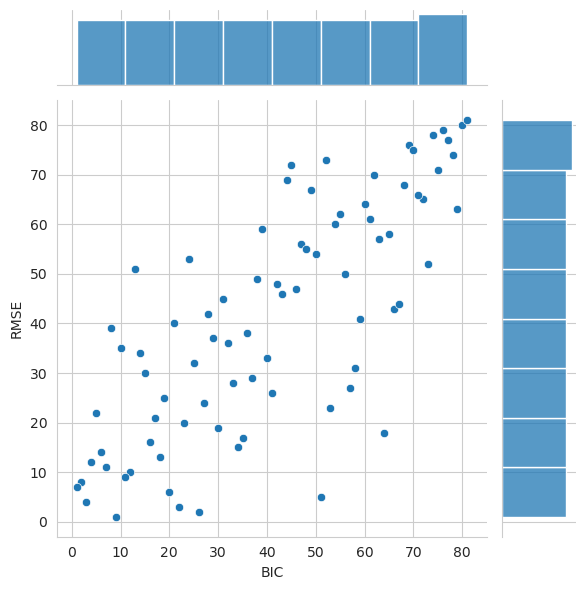

In [98]:
sns.jointplot(y='RMSE', x='BIC', data=sarimax_results[['RMSE', 'BIC']].rank());

In [99]:
sarimax_results[(sarimax_results.RMSE < sarimax_results.RMSE.quantile(.05)) &
                (sarimax_results.BIC < sarimax_results.BIC.quantile(.1))].sort_values('RMSE')

,,,,RMSE,RMSE_std,AIC,AIC_std,BIC,BIC_std,convergence,stationarity,CV
p1,q1,p2,q2,,,,,,,,,
2,3,0,2,0.009006,0.000179,-775.390651,25.861959,-753.090717,25.861959,0.0,0.0,0.01987


### Train best model

In [109]:
p1, q1, p2, q2 = 2, 3, 0, 2

In [110]:
best_model = tsa.SARIMAX(endog=industrial_production_log_diff.values, order=(p1, 0, q1),
                         seasonal_order=(p2, 0, q2, 12)).fit()

In [111]:
print(best_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  348
Model:             SARIMAX(2, 0, 3)x(0, 0, [1, 2], 12)   Log Likelihood                1155.282
Date:                                 Sat, 03 May 2025   AIC                          -2294.563
Time:                                         20:35:51   BIC                          -2263.746
Sample:                                              0   HQIC                         -2282.294
                                                 - 348                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3763      0.122     11.290      0.000       1.137       1

### Check Residual Correlogram

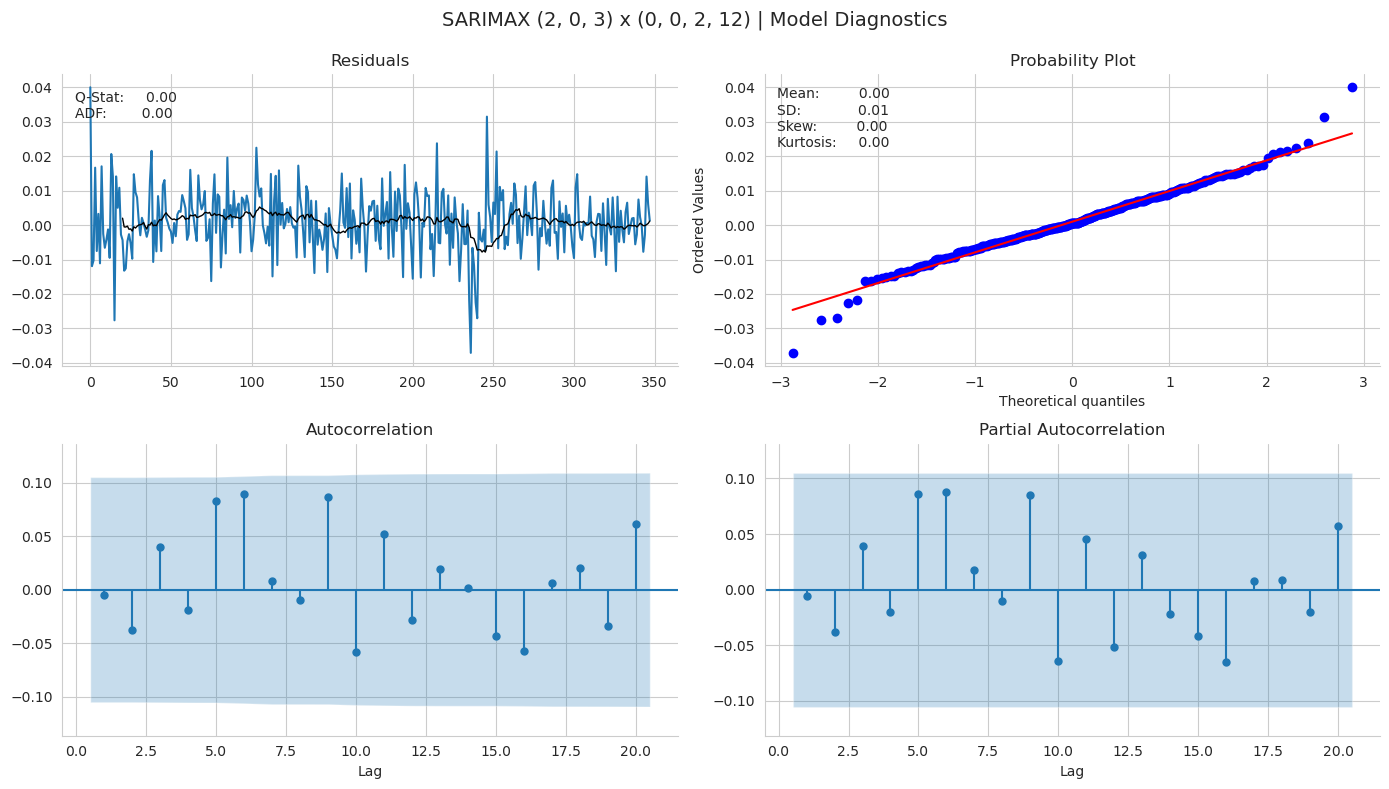

In [112]:
plot_correlogram(pd.Series(best_model.resid),
                 lags=20,
                 title=f'SARIMAX ({p1}, 0, {q1}) x ({p2}, 0, {q2}, 12) | Model Diagnostics')